In [12]:
from glob import glob
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from cobra.flux_analysis import flux_variability_analysis
from matplotlib_venn import venn2
import re
import seaborn as sns

### loading excel with effect of drugs on proteins

In [13]:
InhibitProteinsDF=pd.read_excel("Btheta_2018NeuroInhibit.xlsx", index_col=0 )
InhibitProteinsDF['STITCHid']=InhibitProteinsDF['STITCHid'].str.replace("226186.", "")
InhibitProteinsDF.head()

/tmp/ipykernel_1723/731841849.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  InhibitProteinsDF['STITCHid']=InhibitProteinsDF['STITCHid'].str.replace("226186.", "")


,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
213,BT_1971,WP_011108073_1,catalase,NaN,Prestw-249,Bupropion hydrochloride,N06AX12,human,444,CIDm00000444,604
338,BT_3642,WP_008762587_1,sodium-dependent transporter,NaN,Prestw-17,Levodopa,N04BA01,human,836,CIDm00000836,450
214,BT_1971,WP_011108073_1,catalase,NaN,Prestw-458,Melatonin,N05CH01,human,896,CIDs00000896,604
110,BT_0673,WP_008761351_1,NAD(P)H-dependent oxidoreductase,NaN,Prestw-458,Melatonin,N05CH01,human,896,CIDm00000896,644
292,BT_3186,WP_011108698_1,dihydrolipoyl dehydrogenase,lpdA,Prestw-868,Acetaminophen,N02BE01,human,1983,CIDm00001983,461


## Neuroactive drugs that have STITCH info. and p-value<=0.01(i.e., had effect on bacterium's growth)

In [14]:
s3Info=pd.read_excel('S3_reduced.xlsx')
# s3Info

In [15]:
NeuroPrest=list(InhibitProteinsDF.prestwickID.unique())
Neuros3Info=s3Info.copy()
Neuros3Info=s3Info[s3Info['prestwick_ID'].isin(NeuroPrest)]
# Neuros3Info

In [16]:
lastCol=Neuros3Info.columns[-1]
signifNeuroPaper = Neuros3Info[Neuros3Info[lastCol] <= 0.01]
# signifNeuroPaper
print('number of drugs that had effect on growth in vitro:', len(signifNeuroPaper))

number of drugs that had effect on growth in vitro: 0


## Knock-out effect of each drug

In [17]:
DrugsNamesDF=InhibitProteinsDF.copy()
DrugsNamesDF=DrugsNamesDF[['DrugName','prestwickID']]
DrugsNamesDF.drop_duplicates(inplace=True)

# print(DrugsNamesDF)

UniqueDrugsIdsList=DrugsNamesDF['prestwickID'].unique().tolist()

# UniqueDrugsIdsList
# print(UniqueDrugsIdsList)

ProteinsNamesDF=InhibitProteinsDF.copy()
ProteinsNamesDF=ProteinsNamesDF[['STITCHid','CarveMeID', 'ProteinName', 'symbol']]
ProteinsNamesDF.drop_duplicates(inplace=True)
# print(ProteinsNamesDF)

### proteins in stitch vs model

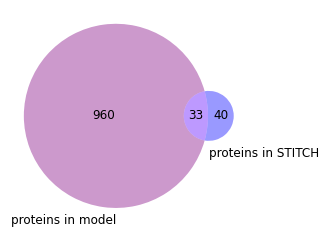

In [18]:
proteinsSTITCH=list(InhibitProteinsDF.STITCHid.unique())
Model=read_sbml_model('Btheta_curated.xml')
proteinsModel=[]
for x in Model.genes:
    proteinsModel.append(x.id)

Venn=venn2([set(proteinsModel), set(proteinsSTITCH)],set_labels=('proteins in model', 'proteins in STITCH'), set_colors=('purple', 'blue'))
for text in Venn.subset_labels:
    text.set_fontsize(12)

# carveme vs curated genes

### Matching ids between genes and proteins

In [19]:
def matchingProteinsIDs(featureTable):
    #read strain "feature_table"
    featuresDF = pd.read_csv(featureTable, delimiter = "\t")
    OldLocusDF=featuresDF.copy()
    OldLocusDF=OldLocusDF[['locus_tag', 'attributes']]
    OldLocusDF=OldLocusDF.dropna(subset = ["attributes"])
    OldLocusDF['attributes'] = OldLocusDF['attributes'].str.split(',', n=1).str.get(-1)
    OldLocusDF['attributes'] = OldLocusDF['attributes'].str.split('=', n=1).str.get(-1)
    RefSeqIDs=featuresDF.copy()
    RefSeqIDs=RefSeqIDs[['product_accession', 'non-redundant_refseq', 'name', 'symbol', 'locus_tag']]
    RefSeqIDs = RefSeqIDs.T.drop_duplicates().T
    allIDsDF=pd.merge(OldLocusDF, RefSeqIDs, on="locus_tag")
    allIDsDF=allIDsDF.dropna(subset = ["product_accession"])
    allIDsDF=allIDsDF.dropna(subset = ["attributes"])
    allIDsDF['product_accession'] = allIDsDF['product_accession'].str.replace('.','_')
    allIDsDF=allIDsDF.rename(columns = {'locus_tag':'RefSeq_id','attributes':'STITCHid', 'product_accession':'CarveMeID', 'name':'ProteinName'})
    allIDsDF['STITCHid'] = '226186.' + allIDsDF['STITCHid'].astype(str)
    return allIDsDF

In [20]:
idsMatch=matchingProteinsIDs('GCF_000011065.1_ASM1106v1_feature_table.txt')
idsMatch

/tmp/ipykernel_1723/1641403634.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  allIDsDF['product_accession'] = allIDsDF['product_accession'].str.replace('.','_')


,RefSeq_id,STITCHid,CarveMeID,ProteinName,symbol
1,BT_RS00005,226186.BT_0001,WP_011107050_1,hypothetical protein,NaN
3,BT_RS00010,226186.BT_0002,WP_009039994_1,hypothetical protein,NaN
5,BT_RS00015,226186.BT_0003,WP_009039993_1,DUF4469 domain-containing protein,NaN
7,BT_RS00020,226186.BT_0004,WP_008647129_1,hypothetical protein,NaN
9,BT_RS00030,226186.BT_0006,WP_011107052_1,hypothetical protein,NaN
...,...,...,...,...,...
9763,BT_RS24270,226186.BT_p548234,WP_005648594_1,recombinase family protein,NaN
9765,BT_RS24275,226186.BT_p548235,WP_011109635_1,Fic family protein,NaN
9767,BT_RS24280,226186.BT_p548236,WP_005648588_1,hypothetical protein,NaN
9769,BT_RS24285,226186.BT_p548237,WP_162303076_1,hypothetical protein,NaN


/tmp/ipykernel_1723/3938583858.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  idsMatch['STITCHid'] = idsMatch['STITCHid'].str.replace('226186.', '')


33
36


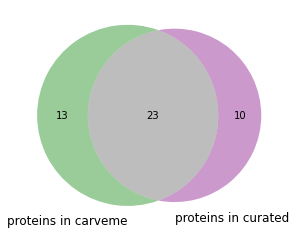

In [21]:
curatedInter=set(proteinsModel).intersection(set(proteinsSTITCH))
print(len(curatedInter))

idsMatch['STITCHid'] = idsMatch['STITCHid'].str.replace('226186.', '')

carvemeModel=read_sbml_model("LBmedium_Btheta_gram_gapFilled_after.xml.gz")
proteinsCarvemeModel=[]
for x in carvemeModel.genes:
    proteinsCarvemeModel.append(x.id)

carvemeGenesDF=idsMatch[idsMatch['CarveMeID'].isin(proteinsCarvemeModel)]
carvemeGenes = carvemeGenesDF['STITCHid'].tolist()

carvemeInter=set(carvemeGenes).intersection(set(proteinsSTITCH))
print(len(carvemeInter))
Venn=venn2([carvemeInter, curatedInter],set_labels=('proteins in carveme', 'proteins in curated'), set_colors=('green', 'purple'))
# for text in Venn.subset_labels:
#     text.set_fontsize(12)

# <span style='color:purple'> **CURATED** </span> model

## for each drug, knock-out <span style='color:red'> **ALL proteins AT THE SAME TIME** </span>

## see how knock-out affects <span style='color:brown'> **GROWTH** </span> 
## <span style='color:brown'> **LB[-O2]** </span>

In [10]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    ObjValue_before=Model.optimize().objective_value
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)

    LB_data=[]
    for drugId in tqdm(UniqueDrugsIdsList): #for each drug
        drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
        genesIdsList=[]
        for x in Model.genes:
            genesIdsList.append(x.id)
        SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
        UniqueProteinIds = SpecificDrugDF['STITCHid'].unique().tolist()
        IP_Stitch=len(UniqueProteinIds)
        ProteinINmodel=[]
        for proteinId in UniqueProteinIds:
            if proteinId in genesIdsList:
                ProteinINmodel.append(proteinId)
        IP_Model=len(ProteinINmodel)
        if ProteinINmodel: #if list is not empty
            with Model as Model:
                cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
                ObjValue_after=Model.optimize().objective_value
                fluxAfter=flux_variability_analysis(Model)            
                fluxAfter=fluxAfter.round(0)
                fluxesCompare=fluxBefore.compare(fluxAfter) 
                TotalAffectedRxs=len(fluxesCompare)       
                percentFBAchange=abs(((ObjValue_after-ObjValue_before)/ObjValue_before)*100)
                percentFBAchange=round(percentFBAchange,0)
                DataRow=[drugId, drugName.item(), IP_Stitch, IP_Model,TotalAffectedRxs, percentFBAchange]
                LB_data.append(DataRow)
        else:
            DataRow=[drugId, drugName.item(), IP_Stitch, IP_Model, IP_Model, 0]
            LB_data.append(DataRow)

    LB_df=pd.DataFrame(LB_data, columns=['drugId', 'drugName', 'StitchInhibtProteins', 'modelInhibtProteins','AffectedRxs', 'Growth%Change'])
    LB_df=LB_df.set_index('drugId')
    LB_df

100%|██████████| 41/41 [00:49<00:00,  1.20s/it]


In [11]:
LB_df

,drugName,StitchInhibtProteins,modelInhibtProteins,AffectedRxs,Growth%Change
drugId,,,,,
Prestw-249,Bupropion hydrochloride,1,1,0,0.0
Prestw-17,Levodopa,1,0,0,0.0
Prestw-458,Melatonin,2,1,0,0.0
Prestw-868,Acetaminophen,14,6,4,0.0
Prestw-74,Amitryptiline hydrochloride,1,0,0,0.0
Prestw-1207,Acetylsalicylic acid,14,4,81,0.0
Prestw-305,Bupivacaine hydrochloride,1,0,0,0.0
Prestw-1256,Caffeine,1,0,0,0.0
Prestw-52,Carbamazepine,16,11,752,100.0


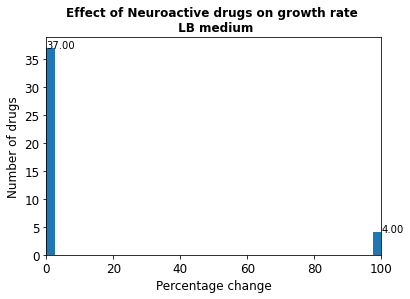

In [7]:
LBpercentDF=LB_df.copy().round(0)
LBpercentDF=LBpercentDF[["Growth%Change"]]
LBpercentDF=pd.DataFrame(LBpercentDF['Growth%Change'].value_counts())
LBpercentDF.index.names = ['change']
LBpercentDF=LBpercentDF.reset_index()
percentVal=LBpercentDF["change"].tolist()
count=LBpercentDF["Growth%Change"].tolist()
# plt.figure(figsize = (6,4))
fig, ax =  plt.subplots(figsize = (6,4))
ax.bar(percentVal, count, width = 5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,100)
plt.title('Effect of Neuroactive drugs on growth rate \n LB medium',fontsize=12, fontweight='bold')
plt.xlabel('Percentage change',fontsize=12)
plt.ylabel('Number of drugs',fontsize=12)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='left', va='top',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
    
# plt.savefig('neuroDrugs_carveme_graphs_lb.png', bbox_inches="tight")

In [8]:
EffectDrugs=LB_df.copy().round(2)
# EffectDrugs=EffectDrugs.reset_index()
# EffectDrugs=EffectDrugs[['LBGrowth%Change', 'AllGrowth%Change', 'm9Growth%Change']]
EffectDrugs=EffectDrugs[['Growth%Change']]
indexList=[]
for index, row in EffectDrugs.iterrows():
    rowDF=EffectDrugs.loc[index]
    rowValues=row.values.tolist()
    res = any(val == 100.00 for val in rowValues)
    if res: #if p<0.05 for at least one cancer subtype 
        indexList.append(index)
print('number of drugs with effect on growth', len(indexList))

number of drugs with effect on growth 4


In [10]:
effectiveDrugs=LB_df.copy()
effectiveDrugs=effectiveDrugs[effectiveDrugs.index.isin(indexList)]
effectiveDrugs

,drugName,StitchInhibtProteins,modelInhibtProteins,AffectedRxs,Growth%Change
drugId,,,,,
Prestw-52,Carbamazepine,16,11,752,100.0
Prestw-1482,Valproic acid,23,15,752,100.0
Prestw-1492,Lamotrigine,16,10,752,100.0
Prestw-1493,Topiramate,13,11,752,100.0


## essential genes affected

In [8]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    essentGenes=cobra.flux_analysis.find_essential_genes(Model, threshold=None, processes=None)
    essentGenesList=[]
    for gene in essentGenes:
        essentGenesList.append(gene.id)
    if "spontaneous" in essentGenesList:
        essentGenesList.remove("spontaneous")
    essentGenesList=set(essentGenesList) #all essential genes in LB carveme model
    neuroGenes=set(list(InhibitProteinsDF.STITCHid.unique())) #genes with interactions with neuro drugs
    essentNeuroGenes=list(essentGenesList.intersection(neuroGenes))
    essentRows=InhibitProteinsDF[InhibitProteinsDF.STITCHid.isin(essentNeuroGenes)] #drugs that interact with essential genes
    essentRows

['BT_0033', 'BT_0057', 'BT_0205', 'BT_0347', 'BT_0373', 'BT_0378', 'BT_0381', 'BT_0382', 'BT_0391', 'BT_0394', 'BT_0398', 'BT_0409', 'BT_0475', 'BT_0477', 'BT_0481', 'BT_0554', 'BT_0558', 'BT_0590', 'BT_0598', 'BT_0602', 'BT_0613', 'BT_0624', 'BT_0629', 'BT_0674', 'BT_0745', 'BT_0748', 'BT_0789', 'BT_0870', 'BT_0875', 'BT_0876', 'BT_1224', 'BT_1225', 'BT_1343', 'BT_1346', 'BT_1355', 'BT_1356', 'BT_1362', 'BT_1368', 'BT_1442', 'BT_1445', 'BT_1446', 'BT_1525', 'BT_1560', 'BT_1644', 'BT_1653', 'BT_1681', 'BT_1708', 'BT_1713', 'BT_1714', 'BT_1715', 'BT_1718', 'BT_1719', 'BT_1720', 'BT_1721', 'BT_1722', 'BT_1880', 'BT_1998', 'BT_1999', 'BT_2002', 'BT_2005', 'BT_2009', 'BT_2011', 'BT_2061', 'BT_2084', 'BT_2123', 'BT_2152', 'BT_2186', 'BT_2231', 'BT_2232', 'BT_2238', 'BT_2242', 'BT_2517', 'BT_2543', 'BT_2747', 'BT_2797', 'BT_2842', 'BT_2863', 'BT_2872', 'BT_3034', 'BT_3164', 'BT_3184', 'BT_3212', 'BT_3219', 'BT_3306', 'BT_3320', 'BT_3358', 'BT_3393', 'BT_3394', 'BT_3447', 'BT_3448', 'BT_3450'

In [15]:
essentRows

,STITCHid,CarveMeID,ProteinName,symbol,prestwickID,DrugName,ATCcodes,targetSpecies,CIDno,item_id_a,score
148,BT_1225,WP_008763415_1,GDP-L-fucose synthase,NaN,Prestw-52,Carbamazepine,N03AF01,human,2554,CIDm00002554,388
29,BT_0382,WP_011107232_1,NAD-dependent epimerase/dehydratase family pro...,NaN,Prestw-52,Carbamazepine,N03AF01,human,2554,CIDm00002554,388
144,BT_1225,WP_008763415_1,GDP-L-fucose synthase,NaN,Prestw-1482,Valproic acid,N03AG01,human,3121,CIDs00003121,388
24,BT_0382,WP_011107232_1,NAD-dependent epimerase/dehydratase family pro...,NaN,Prestw-1482,Valproic acid,N03AG01,human,3121,CIDs00003121,388
26,BT_0382,WP_011107232_1,NAD-dependent epimerase/dehydratase family pro...,NaN,Prestw-1492,Lamotrigine,N03AX09,human,3878,CIDs00003878,388
146,BT_1225,WP_008763415_1,GDP-L-fucose synthase,NaN,Prestw-1492,Lamotrigine,N03AX09,human,3878,CIDs00003878,388
147,BT_1225,WP_008763415_1,GDP-L-fucose synthase,NaN,Prestw-1493,Topiramate,N03AX11,human,5514,CIDm00005514,388
27,BT_0382,WP_011107232_1,NAD-dependent epimerase/dehydratase family pro...,NaN,Prestw-1493,Topiramate,N03AX11,human,5514,CIDm00005514,388


In [16]:
list(essentRows.ProteinName)

['GDP-L-fucose synthase',
 'NAD-dependent epimerase/dehydratase family protein',
 'GDP-L-fucose synthase',
 'NAD-dependent epimerase/dehydratase family protein',
 'NAD-dependent epimerase/dehydratase family protein',
 'GDP-L-fucose synthase',
 'GDP-L-fucose synthase',
 'NAD-dependent epimerase/dehydratase family protein']

# **DIRECTLY** affected neuroactive REACTIONS

In [7]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    neuroRxs=pd.read_excel("curated_neuroRxs.xlsx")
    neuroRxsList=list(neuroRxs.ReactionID.unique())
    df = pd.DataFrame(columns=['NeuroactiveReaction'])
    LB_data=[]
    for drugId in tqdm(UniqueDrugsIdsList): #for each drug
        drugData=[]
        drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
        genesIdsList=[]
        for x in Model.genes:
            genesIdsList.append(x.id)
    #     for modelMetab in Model.metabolites:
    #         modelMetabs.append(modelMetab.id)
        SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
        UniqueProteinIds = SpecificDrugDF['STITCHid'].unique().tolist()
        ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
        for proteinId in UniqueProteinIds:
            if proteinId in genesIdsList:
                ProteinINmodel.append(proteinId)
        if ProteinINmodel: #if list is not empty
            with Model as Model:
                directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
                directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
    #             print(drugName.item(),directAffectNeuro)
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
                Model.optimize()
                fluxAfter=flux_variability_analysis(Model)
                fluxAfter=fluxAfter.round(0)
                fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
        #         print('total number of reactions with changed fluxes', len(fluxesCompare))
                directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
                directAffectNeuroRxs=list(directAffectNeuroDF.index.unique())
    #             print(drugName.item(),directAffectNeuroRxs)
                totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
        #         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
                totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
    #             print(totalNeuroAffectedRxs)
                if directAffectNeuroRxs:
                    for reaction in directAffectNeuroRxs:
                        row=[reaction, True]
                        drugData.append(row)
                    DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveReaction', drugName.item()])
                    print(DrugDF)
                else:
                    DrugDF=None
        else:
            DrugDF=None

        if DrugDF is not None:  
            LB_data.append(DrugDF)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


In [9]:
modelData=LB_data.copy()

In [10]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveReaction', how='outer').fillna(False)
df  

,NeuroactiveReaction


In [11]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub
print('number of directly affected neuroactive reactions', len(noDub))

number of directly affected neuroactive reactions 0


In [12]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveReaction')
# noDub

In [13]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveReaction


In [14]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveReaction


In [ ]:
if not sorteddf.empty:
    plt.figure(figsize = (10,5))

    s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

    s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

    # plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

# **INDIRECTLY** affected neuroactive REACTIONS

In [16]:
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    neuroRxs=pd.read_excel("curated_neuroRxs.xlsx")
    neuroRxsList=list(neuroRxs.ReactionID.unique())
    df = pd.DataFrame(columns=['NeuroactiveReaction'])
    LB_data=[]
    for drugId in tqdm(UniqueDrugsIdsList): #for each drug
        drugData=[]
        drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
        genesIdsList=[]
        for x in Model.genes:
            genesIdsList.append(x.id)
    #     for modelMetab in Model.metabolites:
    #         modelMetabs.append(modelMetab.id)
        SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
        UniqueProteinIds = SpecificDrugDF['STITCHid'].unique().tolist()
        ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
        for proteinId in UniqueProteinIds:
            if proteinId in genesIdsList:
                ProteinINmodel.append(proteinId)
        if ProteinINmodel: #if list is not empty
            with Model as Model:
                directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
                directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
    #             print(drugName.item(),directAffectNeuro)
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
                Model.optimize()
                fluxAfter=flux_variability_analysis(Model)
                fluxAfter=fluxAfter.round(0)
                fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
        #         print('total number of reactions with changed fluxes', len(fluxesCompare))
                directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuroDF))
                directAffectNeuroRxs=list(directAffectNeuroDF.index.unique())
    #             print(drugName.item(),directAffectNeuroRxs)
                totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
        #         print('number of total affected NEUROACTIVE reactions', len(totalNeuroRxsDF))
                totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
    #             print(totalNeuroAffectedRxs)
                if totalNeuroAffectedRxs:
                    for reaction in totalNeuroAffectedRxs:
                        row=[reaction, True]
                        drugData.append(row)
                    DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveReaction', drugName.item()])
    #                 print(DrugDF)
                else:
                    DrugDF=None
        else:
            DrugDF=None

        if DrugDF is not None:  
            LB_data.append(DrugDF)

100%|██████████| 41/41 [00:45<00:00,  1.11s/it]


In [17]:
modelData=LB_data.copy()

In [18]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveReaction', how='outer').fillna(False)
df  

,NeuroactiveReaction,Vigabatrin,Topiramate,Lamotrigine,Gabapentin,Valproic acid,Disulfiram,Carbamazepine,Acetylsalicylic acid
0,26DAPLLATi,True,True,True,True,True,True,True,False
1,PHETA1,True,True,True,True,True,True,True,False
2,ACGS,False,True,True,False,True,True,True,False
3,ACKr,False,True,True,False,True,True,True,False
4,ACODA,False,True,True,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...
78,TRPt2r,False,True,True,False,True,False,True,False
79,TYRTA,False,True,True,False,True,True,True,False
80,UAMAGS,False,True,True,False,True,False,True,False
81,VALTA,False,True,True,False,True,False,True,False


In [19]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub
print('number of INdirectly affected neuroactive reactions', len(noDub))

number of INdirectly affected neuroactive reactions 83


In [20]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveReaction')
# noDub

In [21]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveReaction,26DAPLLATi,PHETA1,ACGS,ACKr,ACODA,ACOTA,ACtr,AGDC,AHSERL2,AHSERL3,...,SKATOLEF,TRPAS2,TRPS1,TRPS2,TRPTA,TRPt2r,TYRTA,UAMAGS,VALTA,GLUDxi
Vigabatrin,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gabapentin,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acetylsalicylic acid,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,1
Disulfiram,1,1,1,1,1,1,0,0,0,0,...,0,1,1,1,0,0,1,0,0,0
Topiramate,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Lamotrigine,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Valproic acid,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
Carbamazepine,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [22]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveReaction,26DAPLLATi,ACGS,ACKr,ACODA,ACOTA,ACtr,AGDC,AHSERL2,AHSERL3,AMAOTr,...,QULNS,SKATOLEF,TRPAS2,TRPS1,TRPS2,TRPTA,TRPt2r,TYRTA,UAMAGS,VALTA
Vigabatrin,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gabapentin,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acetylsalicylic acid,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,0,0,0
Disulfiram,1,1,1,1,1,0,0,0,0,0,...,1,0,1,1,1,0,0,1,0,0
Topiramate,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Lamotrigine,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Valproic acid,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Carbamazepine,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


[Text(0.5, 395.407484939759, 'Neuroactive metabolites'),
 Text(159.0, 0.5, 'Drugs')]

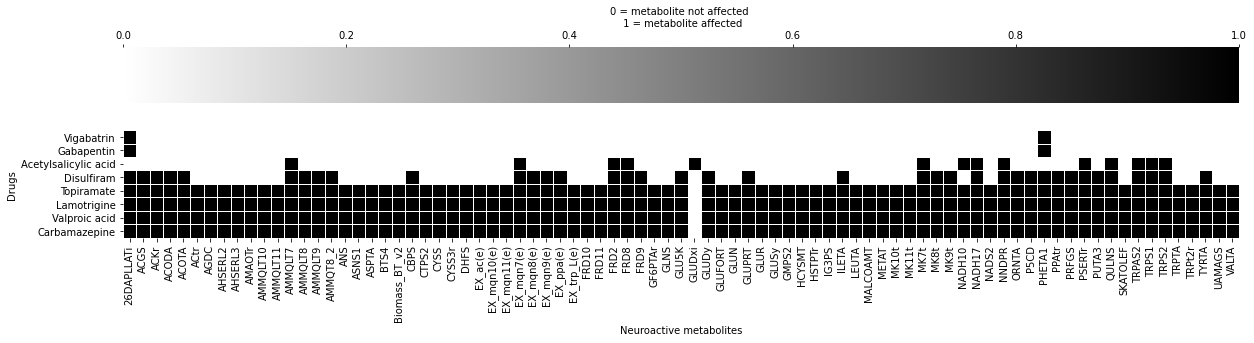

In [23]:
plt.figure(figsize = (20,10))

s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroactiveDrugs_affectedNeuroMetabs_carveme.png', bbox_inches="tight")

## Neuroactive METABOLITES

In [7]:
neuroRxs=pd.read_excel("curated_neuroRxs.xlsx")
neuroRxsList=list(neuroRxs.ReactionID.unique())
NeuroMetabDF=pd.read_excel('curated_neuroMetabs.xlsx')
NeuroMetabList=NeuroMetabDF['BiGGIDnoM'].tolist()
# modelMetabs=[]
df = pd.DataFrame(columns=['NeuroactiveMetabolite'])
M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
M9List=M9Series.index.tolist()
Media=pd.read_excel('carvemeMedia.xlsx')
M9CarvemeMedium=Media['M9'].tolist()
CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
M9Medium=M9List+CarvemeM9Metabs
LBmediumList=Media['LB'].tolist()
LBmedium=LBmediumList+M9Medium
MediumList=[LBmedium]
for medium in MediumList:
    Model=read_sbml_model('Btheta_curated.xml')  
    Model.optimize()
    ModelMedium=[v for v in Model.medium.keys()] # has all Exchange reactions active
    ModelMedium.remove("EX_glc(e)")
    Model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)        
    for mediumRx in ModelMedium: #go through each reaction in medium
        if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
            Model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
    for Ex_rx in Model.medium.keys():
        Model.reactions.get_by_id(Ex_rx).lower_bound = -10
        Model.reactions.get_by_id(Ex_rx).upper_bound = 1000
    Model.optimize()
    fluxBefore=flux_variability_analysis(Model)
    fluxBefore=fluxBefore.round(0)
    LB_data=[]
    for drugId in tqdm(UniqueDrugsIdsList): #for each drug
        drugData=[]
        drugName=DrugsNamesDF.loc[DrugsNamesDF['prestwickID'] == drugId, 'DrugName']
        genesIdsList=[]
        for x in Model.genes:
            genesIdsList.append(x.id)
    #     for modelMetab in Model.metabolites:
    #         modelMetabs.append(modelMetab.id)
        SpecificDrugDF = InhibitProteinsDF[InhibitProteinsDF['prestwickID'] == drugId] #for each drug, get the corresponding rows
        UniqueProteinIds = SpecificDrugDF['STITCHid'].unique().tolist()
        ProteinINmodel=[] #proteins that have STITCH info. and exist in the model
        for proteinId in UniqueProteinIds:
            if proteinId in genesIdsList:
                ProteinINmodel.append(proteinId)
        if ProteinINmodel: #if list is not empty
            with Model as Model:
                directAffectRxs=cobra.manipulation.knock_out_model_genes(Model, ProteinINmodel)
                directAffectNeuro=list(set(directAffectRxs).intersection(set(neuroRxsList))) #from directly affected rxs, are there neuroactive ones?
        #         print('number of directly affected NEUROACTIVE reactions', len(directAffectNeuro))
                Model.optimize()
                fluxAfter=flux_variability_analysis(Model)
                fluxAfter=fluxAfter.round(0)
                fluxesCompare=fluxBefore.compare(fluxAfter) #only keeps rows that at least on the values changed
                directAffectNeuroDF=fluxesCompare[fluxesCompare.index.isin(directAffectNeuro)]
                totalNeuroRxsDF=fluxesCompare[fluxesCompare.index.isin(neuroRxsList)]
                totalNeuroAffectedRxs=list(totalNeuroRxsDF.index.unique())
                if totalNeuroAffectedRxs:
                    for reaction in totalNeuroAffectedRxs:
                        metabs=Model.reactions.get_by_id(reaction).metabolites
                        metlist=[]
                        for met in metabs:
                            metlist.append(met)
                            metlist
                            metlistids=[]
                        for m in metlist:
                            metlistids.append(m.id)
#                         metlistids = [re.sub('\[', '_', metabolito) for metabolito in metlistids]
#                         metlistids = [re.sub('\]', '', metabolito) for metabolito in metlistids]
                        for Metab in metlistids:
                            if Metab in NeuroMetabList:
                                row=[Metab, True]
                                drugData.append(row)
                                
                    DrugDF=pd.DataFrame(drugData, columns=['NeuroactiveMetabolite', drugName.item()])
                else:
                    DrugDF=pd.DataFrame()
        else:
            DrugDF=pd.DataFrame()

        if not DrugDF.empty:   
            LB_data.append(DrugDF)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


In [ ]:
modelData=LB_data.copy()
modelData

In [9]:
for each_DF in LB_data:
    df=pd.merge(each_DF, df, on='NeuroactiveMetabolite', how='outer').fillna(False)
# df  

In [15]:
noDub=df.copy()
noDub=noDub.drop_duplicates()
# noDub

In [16]:
noDub=noDub*1 #from bool values to binary values
noDub=noDub.set_index('NeuroactiveMetabolite')
# noDub

In [17]:
noDub=noDub.T
noDub["number of models"] = noDub.sum(axis=1) 
noDub= noDub.sort_values(by=['number of models'])
noDub=noDub.drop(columns=['number of models'])
noDub

NeuroactiveMetabolite,glu-L[c],ac[c],ac[e],amet[c],mqn8[c],trp-L[c],mqn10[e],mqn11[e],mqn7[e],mqn8[e],mqn9[e],ppa[e],trp-L[e],mqn10[c],mqn11[c],mqn7[c],mqn9[c],glu-D[c],quln[c],ppa[c]
Vigabatrin,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Gabapentin,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Acetylsalicylic acid,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0
Disulfiram,1,1,0,1,1,1,0,0,1,1,1,1,0,0,0,1,1,0,1,1
Topiramate,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Lamotrigine,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Valproic acid,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Carbamazepine,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [13]:
sorteddf=noDub.copy()
sorteddf = sorteddf.reindex(sorted(sorteddf.columns), axis=1)
sorteddf

NeuroactiveMetabolite,ac[c],ac[e],amet[c],glu-D[c],glu-L[c],mqn10[c],mqn10[e],mqn11[c],mqn11[e],mqn7[c],mqn7[e],mqn8[c],mqn8[e],mqn9[c],mqn9[e],ppa[c],ppa[e],quln[c],trp-L[c],trp-L[e]
Vigabatrin,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Gabapentin,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Acetylsalicylic acid,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0
Disulfiram,1,0,1,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0
Topiramate,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Lamotrigine,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Valproic acid,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Carbamazepine,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


[Text(0.5, 13.999999999999957, 'Neuroactive metabolites'),
 Text(66.19999999999995, 0.5, 'Drugs')]

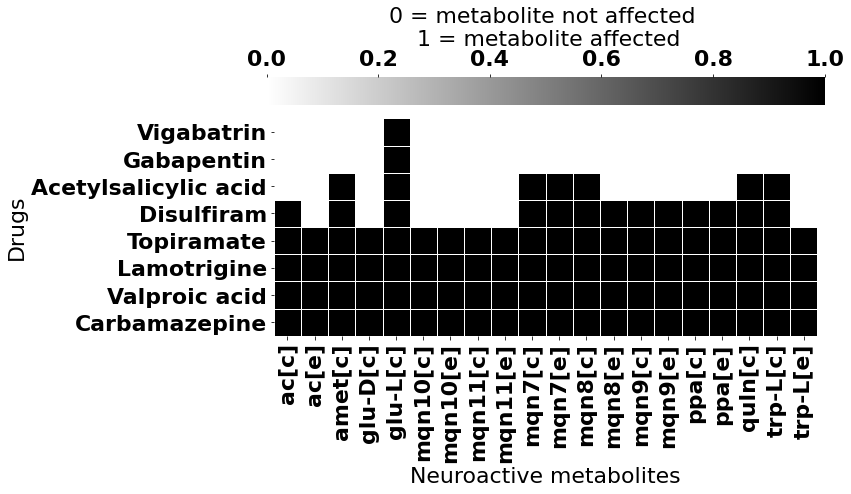

In [14]:
plt.figure(figsize = (10,5))


font = {'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

s=sns.heatmap(sorteddf, cmap=plt.get_cmap('binary'), xticklabels=True, yticklabels=True, cbar_kws={'label': '0 = metabolite not affected \n 1 = metabolite affected', 'location': 'top'}, linewidths=0.5, square=True)

s.set(xlabel='Neuroactive metabolites', ylabel='Drugs')

# plt.savefig('neuroDrugs_affectedNeuroMetabs_curated.png', bbox_inches="tight")